In [1]:
import sys
sys.path.append('../../../build')
import numpy as np
import libry as ry
import matplotlib.pyplot as plt

**ry-c++-log** ry.cpp:init_LogToPythonConsole:34(0) initializing ry log callback

**ry-c++-log** util.cpp:initCmdLine:545(1) ** cmd line arguments: 'rai-pybind -python '
** INFO:ry.cpp:init_LogToPythonConsole:34(0) initializing ry log callback

**ry-c++-log** util.cpp:initCmdLine:549(1) ** run path: '/home/vasko/Documents/TUB3/AI_Robotics/robotics-course/course3-Simulation/04-opencv/solutions'
** INFO:util.cpp:initCmdLine:545(1) ** cmd line arguments: 'rai-pybind -python '

**ry-c++-log** graph.cpp:initParameters:1379(1) ** parsed parameters:
{python}

** INFO:util.cpp:initCmdLine:549(1) ** run path: '/home/vasko/Documents/TUB3/AI_Robotics/robotics-course/course3-Simulation/04-opencv/solutions'

** INFO:graph.cpp:initParameters:1379(1) ** parsed parameters:
{python}



In [2]:
RealWorld = ry.Config()
RealWorld.addFile('../../../scenarios/pandasTable.g')

obj = RealWorld.addFrame("object")
obj.setShape(ry.ST.ssBox, [0.3, 0.2, 0.1, 0.02])
obj.setColor([1,0,0])
obj.setPosition([0.5, 0.1, 0.7])
obj.setQuaternion([1,0,0,0.5])

cameraFrame = RealWorld.addFrame("myCamera")
cameraFrame.setShape(ry.ST.marker, [0.3])
# cameraFrame.setPosition([0,0,2.0])
cameraFrame.setPosition([0,1.0,2.0])
cameraFrame.setQuaternion([1,-0.5,0,1])

f, W, H = 1., 600, 200
S = RealWorld.simulation(ry.SimulatorEngine.bullet, True)
S.addSensor("myCamera", "myCamera", W, H, f) # R_gripperCamera is a fresh frame - we have to specify intrinsic parameters explicitly

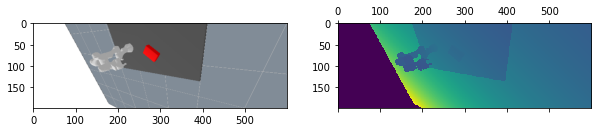

In [3]:
rgb, depth = S.getImageAndDepth()

fig = plt.figure(figsize=(10,5))
axs = fig.subplots(1, 2)
axs[0].imshow(rgb)
axs[1].matshow(depth)
plt.show()

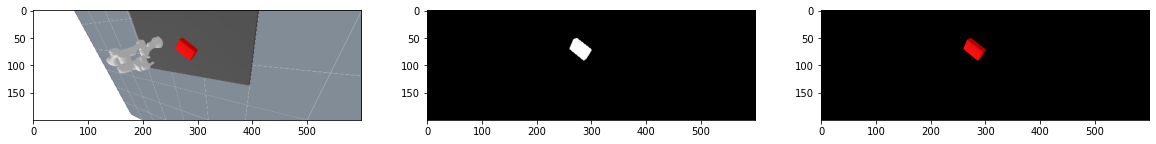

In [4]:
import cv2 as cv

fig = plt.figure(figsize=(20,10))
axs = fig.subplots(1, 3)

image = rgb

result = image.copy()
 
image_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
 
# lower boundary RED color range values; Hue (0 - 10)
lower1 = np.array([0, 100, 20])
upper1 = np.array([10, 255, 255])
 
# upper boundary RED color range values; Hue (160 - 180)
lower2 = np.array([160,100,20])
upper2 = np.array([179,255,255])
 
lower_mask = cv.inRange(image_hsv, lower1, upper1)
upper_mask = cv.inRange(image_hsv, lower2, upper2)
 
full_mask = lower_mask + upper_mask;
 
result = cv.bitwise_and(result, result, mask=full_mask)

mask_greyscale = np.repeat(full_mask[:,:,np.newaxis],3,axis=2)

axs[0].imshow(image)
axs[1].imshow(mask_greyscale)
axs[2].imshow(result)
# cv.imshow('mask', full_mask)
# cv.imshow('result', result)

# cv.waitKey(0)
# cv.destroyAllWindows()
plt.show()

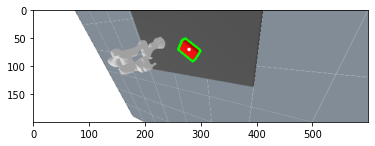

In [5]:
contours, hierarchy = cv.findContours(cv.cvtColor(mask_greyscale, cv.COLOR_RGB2GRAY),cv.RETR_TREE,cv.CHAIN_APPROX_NONE)
M = cv.moments(contours[0])
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
# draw the contour and center of the shape on the image
# cv2.drawContours(image, [c], -1, (0, 255, 0), 2)

    
cv.drawContours(image, contours, -1, (0,255,0), 3)
cv.circle(image, (cX, cY), 3, (255, 255, 255), -1)
plt.imshow(image)

In [13]:
contours[0].shape

(97, 1, 2)

From the lecture slides, we learned
$$\hat x = f\frac{X}{Z}+p_x,~\hat y = f\frac{Y}{Z}+p_y,$$
where
- $\hat x, \hat y$ are image coordinates ($u$-$v$ or pixel),
- $X, Y, Z$ represent camera coordinates, and
- $p_x, p_y$ are the image offset.

Since we know the $Z$ value of each pixel, we can compute their 3D coordinate (in camera frame):
$$ X = Z\frac{\hat x-p_x}{f},~  Y = Z\frac{\hat y-p_y}{f}.$$

Note that the units of intrinsic parameters should be changed as we want to work in pixel coordinate, i.e., $[-0.5,0.5] \rightarrow [0, H] \text{ in pixel}$:
$$f \rightarrow f*H,~ p_x = W/2,~ p_y = H/2.$$

In [ ]:
fx, fy = f*H, f*H
px, py = W/2, H/2
R, t = cameraFrame.getRotationMatrix(), cameraFrame.getPosition()

C = ry.Config()
D = C.view()
points = np.zeros((H,W,3))
for i in range(H):
    for j in range(W):
        Z = depth[i,j]
        if Z < 0:
            continue
            
        ## depth is sign-fliped, j: right, i: down
        points[i,j,0] = Z * (j - px) / fx;
        points[i,j,1] = -Z * (i - py) / fy;
        points[i,j,2] = -Z
        
        ## Coordinate transformation (from camera to world) 
        points[i,j] = R@points[i,j] + t
        
        tmp = C.addFrame("pc"+str(i)+str(j))
        tmp.setShape(ry.ST.sphere, [0.02])
#         tmp.setColor([1,0,0])
        tmp.setColor(rgb[i,j]/255)
        tmp.setPosition(points[i,j])

In [4]:
# Same
C2 = ry.Config()
D2 = C2.view()
cameraFrame2 = C2.addFrame("camera")
cameraFrame2.setPosition(cameraFrame.getPosition())
cameraFrame2.setQuaternion(cameraFrame.getQuaternion())

points = S.depthData2pointCloud(depth, [f*H, f*H, W/2, H/2])
cameraFrame2.setPointCloud(points, rgb)